In [1]:
# Import semua library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# **Langkah 1: Membaca Dataset Heart Disease**
# Membaca dataset heart.csv
file_path = 'heart.csv'  # Sesuaikan dengan path file Anda
df = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama data
print("Dataset Heart Disease:\n", df.head())

# Statistik dasar dari data
print("Statistik Deskriptif:\n", df.describe())

Dataset Heart Disease:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
Statistik Deskriptif:
                age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.0000

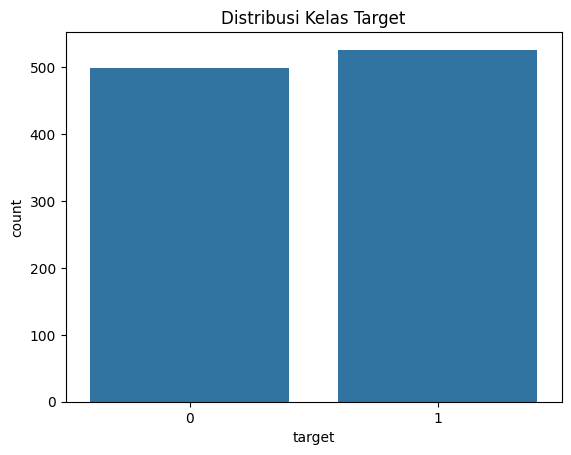

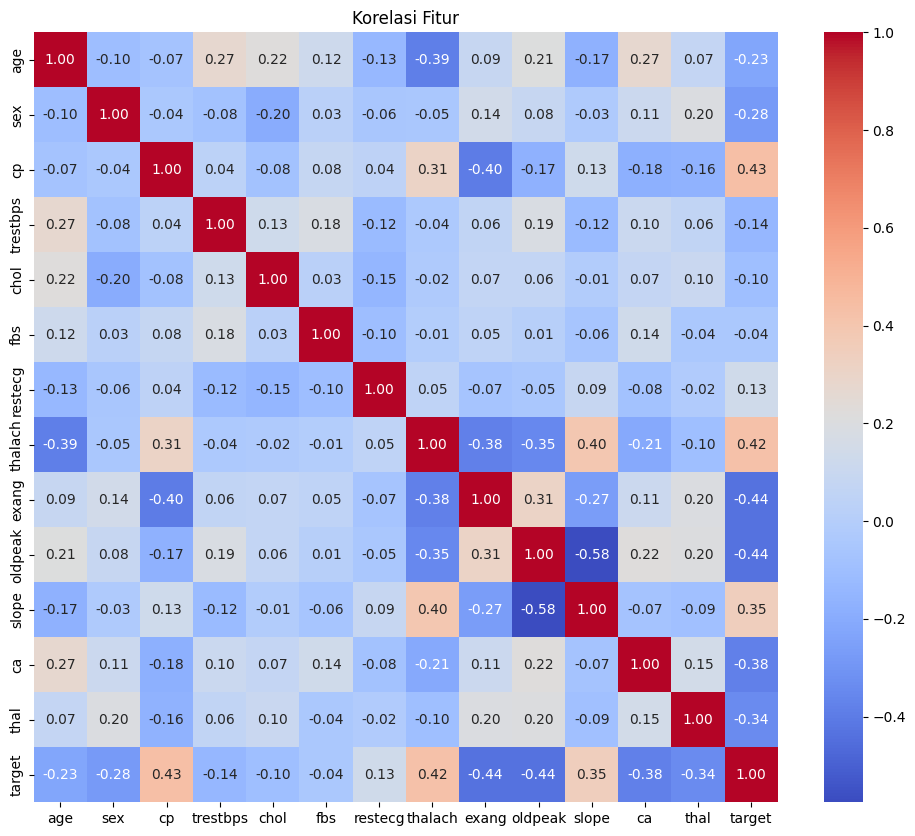

In [5]:
# **Langkah 2: Exploratory Data Analysis (EDA)**
# Grafik distribusi target
sns.countplot(x='target', data=df)
plt.title('Distribusi Kelas Target')
plt.show()

# Heatmap korelasi antar fitur
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korelasi Fitur')
plt.show()


In [6]:
# **Langkah 3: Membagi Data menjadi Train dan Test Set**
# Memisahkan fitur dan target
X = df.drop(columns=['target'])
y = df['target']

# Komentar: Data dipecah menjadi data latih dan uji untuk evaluasi model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standarisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Konversi data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [7]:
# **Langkah 4: Membuat Model MLP dengan Variasi Parameter**
def create_mlp_model(input_dim, hidden_layers, activation_fn):
    layers = []
    for neurons in hidden_layers:
        layers.append(nn.Linear(input_dim, neurons))
        layers.append(activation_fn)
        input_dim = neurons
    layers.append(nn.Linear(input_dim, 2))  # Output layer untuk 2 kelas
    return nn.Sequential(*layers)

# Parameter yang akan dibandingkan
hidden_layer_configs = [[4], [8, 4], [16, 8, 4]]  # Variasi hidden layers
activation_functions = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "Linear": nn.Identity(),
    "Softmax": nn.Softmax(dim=1)
}
epochs_options = [10, 25, 50, 100]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]

# Variabel untuk menyimpan hasil terbaik
best_accuracy = 0
best_config = None


In [8]:
# **Langkah 5: Melakukan Training dan Evaluasi**
for hidden_layers in hidden_layer_configs:
    for activation_name, activation_fn in activation_functions.items():
        for epochs in epochs_options:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Membuat model
                    model = create_mlp_model(X_train_tensor.shape[1], hidden_layers, activation_fn)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Membuat DataLoader
                    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                    # Training
                    model.train()
                    for epoch in range(epochs):
                        for batch_X, batch_y in train_loader:
                            optimizer.zero_grad()
                            outputs = model(batch_X)
                            loss = criterion(outputs, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Evaluasi
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(X_test_tensor)
                        y_pred_classes = torch.argmax(y_pred, axis=1)
                        acc = accuracy_score(y_test, y_pred_classes.numpy())

                    # Menyimpan hasil terbaik
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_config = {
                            "hidden_layers": hidden_layers,
                            "activation": activation_name,
                            "epochs": epochs,
                            "learning_rate": lr,
                            "batch_size": batch_size
                        }

                    print(f"Config: HL={hidden_layers}, Act={activation_name}, Ep={epochs}, LR={lr}, BS={batch_size}, Acc={acc:.4f}")




Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=16, Acc=0.8195
Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=32, Acc=0.8341
Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=64, Acc=0.8585
Config: HL=[4], Act=ReLU, Ep=10, LR=0.1, BS=128, Acc=0.8585
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=16, Acc=0.8244
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=32, Acc=0.8293
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=64, Acc=0.7951
Config: HL=[4], Act=ReLU, Ep=10, LR=0.01, BS=128, Acc=0.8098
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=16, Acc=0.7902
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=32, Acc=0.7707
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=64, Acc=0.7512
Config: HL=[4], Act=ReLU, Ep=10, LR=0.001, BS=128, Acc=0.5024
Config: HL=[4], Act=ReLU, Ep=10, LR=0.0001, BS=16, Acc=0.6439
Config: HL=[4], Act=ReLU, Ep=10, LR=0.0001, BS=32, Acc=0.4976
Config: HL=[4], Act=ReLU, Ep=10, LR=0.0001, BS=64, Acc=0.5317
Config: HL=[4], Act=ReLU, Ep=10, LR=0.0001, BS=128, Acc=0.5951
Config: HL=[4], Act=ReLU, Ep

In [9]:
# Menampilkan hasil terbaik
print("Hasil Terbaik:", best_config)
print(f"Akurasi Terbaik: {best_accuracy:.4f}")

Hasil Terbaik: {'hidden_layers': [8, 4], 'activation': 'ReLU', 'epochs': 100, 'learning_rate': 0.01, 'batch_size': 64}
Akurasi Terbaik: 0.9902
